This example illustrates the diode recovery time and the capacitive
behaviour of a PN junction.


In [ ]:

# Fixme: Split the plots ? Add some explanations at the end


import numpy as np
import matplotlib.pyplot as plt


import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()


from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Probe.Plot import plot
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *


libraries_path = find_libraries()
spice_library = SpiceLibrary(libraries_path)




Let define some parameters


In [ ]:

dc_offset = 1@u_V
ac_amplitude = 100@u_mV




We will first compute some quiescent points and the corresponding
dynamic resistance.


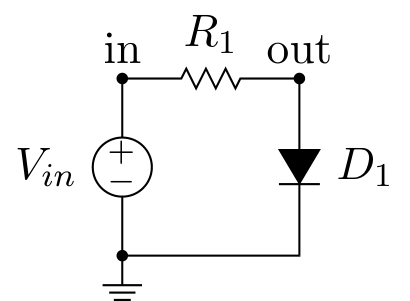

Since this circuit is equivalent to a voltage divider, we can write the
following relation :

$$V_{out} = \frac{Z_d}{R_1 + Z_d} V_{in}$$

where $Z_d$ is the diode impedance.


In [ ]:

circuit = Circuit('Diode')
circuit.include(spice_library['BAV21'])
# Fixme: Xyce: Device model BAV21: Illegal parameter(s) given for level 1 diode: IKF
source = circuit.V('input', 'in', circuit.gnd, dc_offset)
circuit.R(1, 'in', 'out', 1@u_kΩ)
circuit.D('1', 'out', circuit.gnd, model='BAV21')

quiescent_points = []
for voltage in (dc_offset - ac_amplitude, dc_offset, dc_offset + ac_amplitude):
    source.dc_value = voltage
    simulator = circuit.simulator(temperature=25, nominal_temperature=25)
    analysis = simulator.operating_point()
    # Fixme: handle unit
    quiescent_voltage = float(analysis.out)
    quiescent_current = - float(analysis.Vinput)
    quiescent_points.append(dict(voltage=voltage,
                                 quiescent_voltage=quiescent_voltage,
                                 quiescent_current=quiescent_current))
    print("Quiescent Point {:.1f} mV {:.1f} mA".format(quiescent_voltage*1e3, quiescent_current*1e3))


Quiescent Point 561.1 mV 0.3 mA
Quiescent Point 575.0 mV 0.4 mA
Quiescent Point 586.6 mV 0.5 mA


In [ ]:

dynamic_resistance = ((quiescent_points[ 0]['quiescent_voltage'] -
                       quiescent_points[-1]['quiescent_voltage'])
                      /
                      (quiescent_points[ 0]['quiescent_current'] -
                       quiescent_points[-1]['quiescent_current']))



We found a dynamic resistance of 146.6 Ω.


We will now drive the diode with a sinusoidal source and perform an AC
analysis.


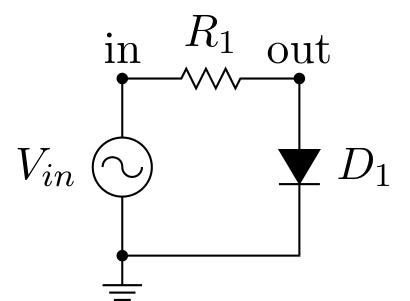

In [ ]:

circuit = Circuit('Diode')
circuit.include(spice_library['BAV21'])
circuit.SinusoidalVoltageSource('input', 'in', circuit.gnd,
                   dc_offset=dc_offset, offset=dc_offset,
                   amplitude=ac_amplitude)
R = circuit.R(1, 'in', 'out', 1@u_kΩ)
circuit.D('1', 'out', circuit.gnd, model='BAV21')

simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.ac(start_frequency=10@u_kHz, stop_frequency=1@u_GHz, number_of_points=10,  variation='dec')



Let plot the voltage across the diode and the dynamic resistance as a
function of the frequency.


In [ ]:

figure, (ax1, ax2, ax3)  = plt.subplots(ncols=3, figsize=(20, 10))

# Fixme: handle unit in plot (scale and legend)
ax1.semilogx(analysis.frequency, np.absolute(analysis.out)*1e3)
ax1.grid(True)
ax1.grid(True, which='minor')
ax1.set_xlabel("Frequency [Hz]")
ax1.set_ylabel("Vd [mV]")

current = (analysis['in'] - analysis.out) / float(R.resistance)
ax2.semilogx(analysis.frequency, np.absolute(analysis.out/current))
ax2.grid(True)
ax2.grid(True, which='minor')
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel('Rd [Ω]')




Text(0, 0.5, 'Rd [Ω]')

We will now drive the diode with a pulse generator and perform a
transient analysis.


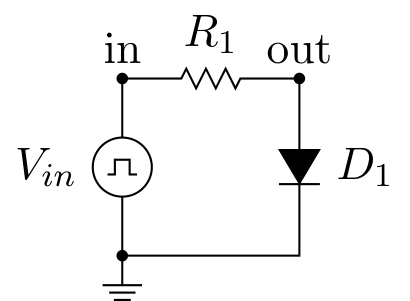

In [ ]:

frequency = 1@u_MHz

circuit = Circuit('Diode')
circuit.include(spice_library['BAV21'])
# source = circuit.SinusoidalVoltageSource('input', 'in', circuit.gnd,
#                             dc_offset=dc_offset, offset=dc_offset,
#                             amplitude=ac_amplitude,
#                             frequency=frequency)
source = circuit.PulseVoltageSource('input', 'in', circuit.gnd,
                       initial_value=dc_offset-ac_amplitude, pulsed_value=dc_offset+ac_amplitude,
                       pulse_width=frequency.period/2, period=frequency.period)
circuit.R(1, 'in', 'out', 1@u_kΩ)
circuit.D('1', 'out', circuit.gnd, model='BAV21')

simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.transient(step_time=source.period/1e3, end_time=source.period*4)

# Fixme: axis, x scale
# plot(analysis['in'] - dc_offset + quiescent_points[0]['quiescent_voltage'])
# plot(analysis.out)
ax3.plot(analysis.out.abscissa*1e6, analysis.out)
ax3.legend(('Vin [V]', 'Vout [V]'), loc=(.8,.8))
ax3.grid()
ax3.set_xlabel('t [μs]')
ax3.set_ylabel('[V]')
# ax3.set_ylim(.5, 1 + ac_amplitude + .1)

plt.tight_layout()



We notice the output of the circuit cannot follow the pulse generator.
It is due to the capacitive behaviour of a PN junction that cut off the
highest frequencies of the pulse. The plot of the dynamic resistance as
a function of the frequency show a typical low pass filter behaviour
where the impedance drop at high frequencies.
